# This Training Code uses the Random Forest Classifier + Smote + Grid Search Hyper Parameter Tuning

In [6]:
def run_LASMaL_random_forest_training(activity_column,
                              csv_path='Activity_Stress_data_N24_modified.csv',
                              k=5,
                              save=True,
                              save_dir='models_kfold_lasmal'):

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import joblib
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
    from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
    from sklearn.preprocessing import LabelEncoder, label_binarize
    from imblearn.over_sampling import SMOTE

    # 📄 Load and preprocess
    df = pd.read_csv(csv_path)
    df = df[['Participant', 'HR_Normalized', 'Cadence', 'Speed', activity_column]].dropna()

    X = df[['HR_Normalized', 'Cadence', 'Speed']]
    y = df[activity_column]
    groups = df['Participant']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    y_binarized = label_binarize(y_encoded, classes=np.unique(y_encoded))
    n_classes = y_binarized.shape[1]

    # 🌲 Model & Hyperparameters
    base_model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'class_weight': ['balanced'],
        'criterion': ['gini'],
        'max_samples': [None]
    }

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=StratifiedGroupKFold(n_splits=3),
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X, y_encoded, groups=groups)
    best_model_base = grid.best_estimator_

    print(f"\n✅ Best Parameters for {activity_column} (LASMaL):")
    print(grid.best_params_)

    # 🔁 k-Fold Cross-Validation with SMOTE
    cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=42)
    mean_fpr = np.linspace(0, 1, 100)
    tpr_folds = {i: [] for i in range(n_classes)}
    aucs = {i: [] for i in range(n_classes)}
    f1_scores = []
    all_y_true, all_y_pred = [], []

    for train_idx, test_idx in cv.split(X, y_encoded, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        sm = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

        best_model = RandomForestClassifier(**grid.best_params_, random_state=42)
        best_model.fit(X_train_resampled, y_train_resampled)

        y_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tpr_folds[i].append(tpr_interp)
            aucs[i].append(auc(fpr, tpr))

        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    # 📈 Plot Mean ROC
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        mean_tpr = np.mean(tpr_folds[i], axis=0)
        mean_auc = np.mean(aucs[i])
        plt.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Mean ROC Curve - {activity_column} (LASMaL, {k}-Fold CV)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # 📊 Plot ROC ± Std Dev
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        tprs = np.array(tpr_folds[i])
        mean_tpr = tprs.mean(axis=0)
        std_tpr = tprs.std(axis=0)
        mean_auc = np.mean(aucs[i])
        std_auc = np.std(aucs[i])
        plt.plot(mean_fpr, mean_tpr, label=f"{class_names[i]} (AUC = {mean_auc:.2f} ± {std_auc:.2f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Mean ROC ± StdDev - {activity_column} (LASMaL, {k}-Fold CV)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # 📝 Classification Report
    print(f"\n📊 Classification Report (LASMaL):")
    print(pd.DataFrame(classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)).T[['precision', 'recall', 'f1-score', 'support']])

    # 🔷 Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {activity_column}')
    plt.tight_layout()
    plt.show()

    # 🌟 Feature Importance
    plt.figure(figsize=(8, 6))
    feature_names = X.columns
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)
    plt.barh(range(len(importances)), importances[sorted_idx], align='center')
    plt.yticks(range(len(importances)), feature_names[sorted_idx])
    plt.title(f'Feature Importance - {activity_column}')
    plt.tight_layout()
    plt.show()

    # 💾 Save model + encoder
    if save:
        os.makedirs(save_dir, exist_ok=True)
        model_path = os.path.join(save_dir, f"{activity_column}_best_model_lasmal.pkl")
        le_path = os.path.join(save_dir, f"{activity_column}_label_encoder_lasmal.pkl")
        joblib.dump(best_model_base, model_path)
        joblib.dump(le, le_path)
        print(f"\n💾 Model saved to: {model_path}")
        print(f"💾 Label encoder saved to: {le_path}")


# Trainig the model using 3 fold cross validation and saving the model

Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Best Parameters for Activity (LASMaL):
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


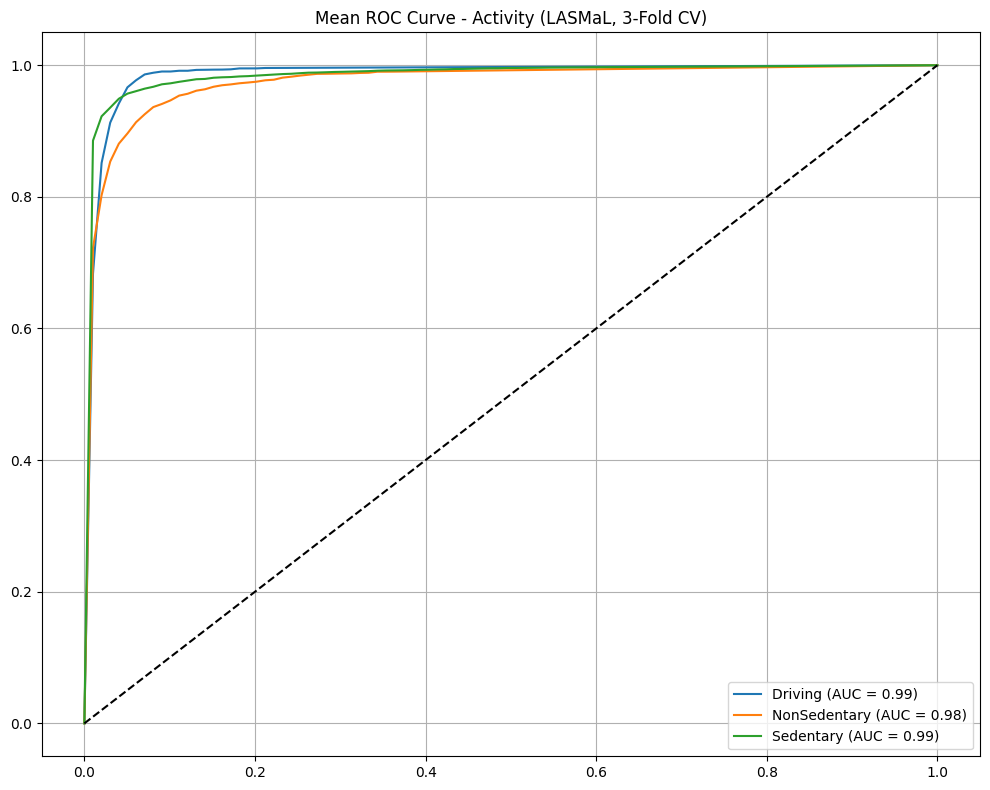

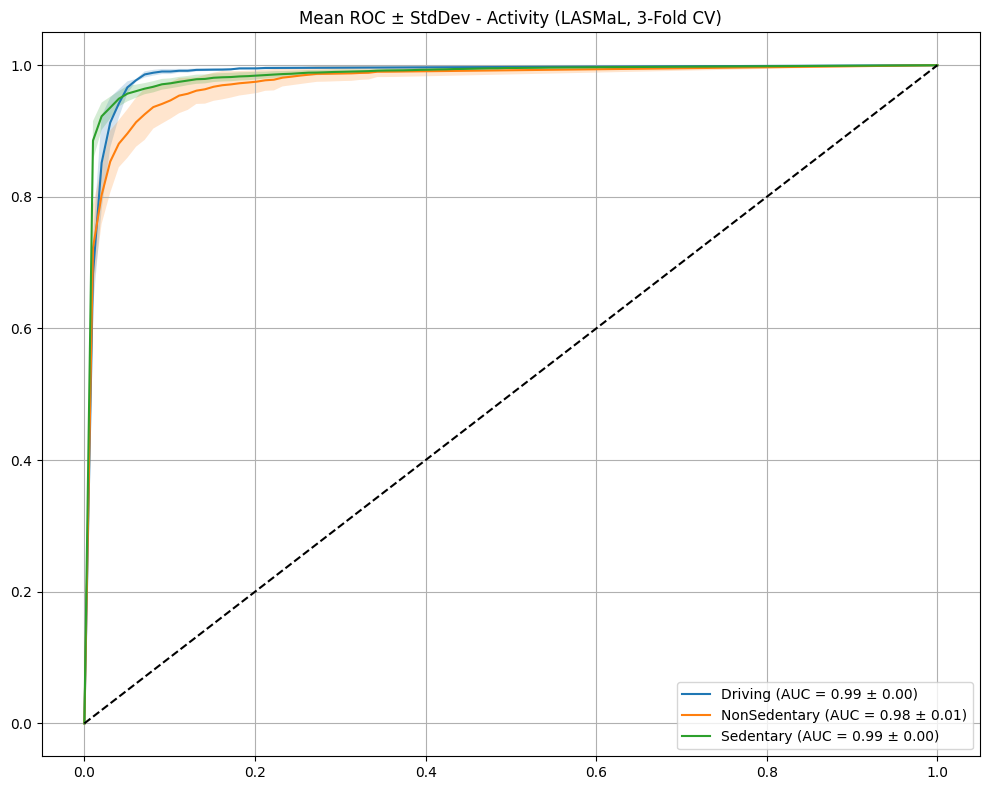


📊 Classification Report (LASMaL):
              precision    recall  f1-score       support
Driving        0.737250  0.858002  0.793056   1331.000000
NonSedentary   0.731682  0.856798  0.789313   1655.000000
Sedentary      0.989225  0.956545  0.972611  15165.000000
accuracy       0.940224  0.940224  0.940224      0.940224
macro avg      0.819386  0.890448  0.851660  18151.000000
weighted avg   0.947265  0.940224  0.942731  18151.000000


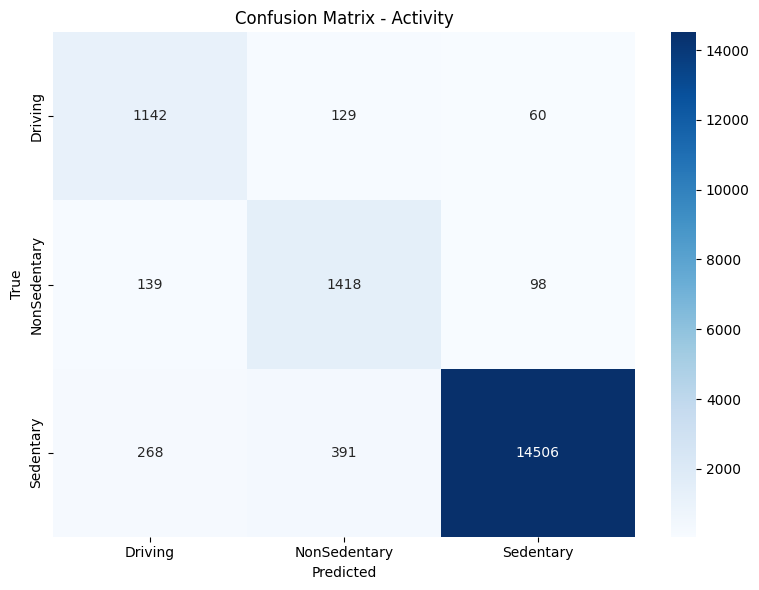

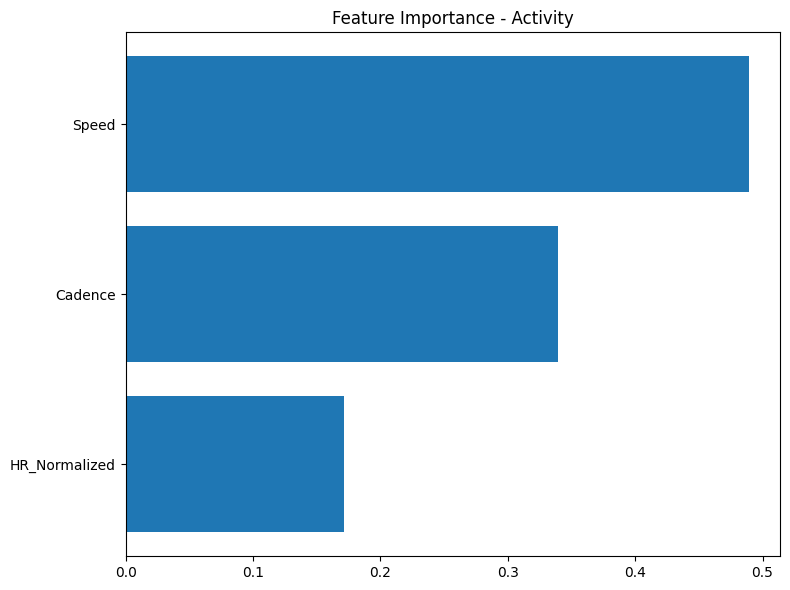


💾 Model saved to: savedmodels/models_k3_lasmal_RandomForest/Activity_best_model_lasmal.pkl
💾 Label encoder saved to: savedmodels/models_k3_lasmal_RandomForest/Activity_label_encoder_lasmal.pkl


In [8]:
# Use 3-fold cross-validation
run_LASMaL_random_forest_training(
    activity_column='Activity',
    csv_path='Activity_Stress_data_N24_with_Activity.csv',
    k=3,
    save=True,
    save_dir='savedmodels/models_k3_lasmal_RandomForest'
)


# Training the model using 5 fold cross validation and saving the model

Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Best Parameters for Activity (LASMaL):
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


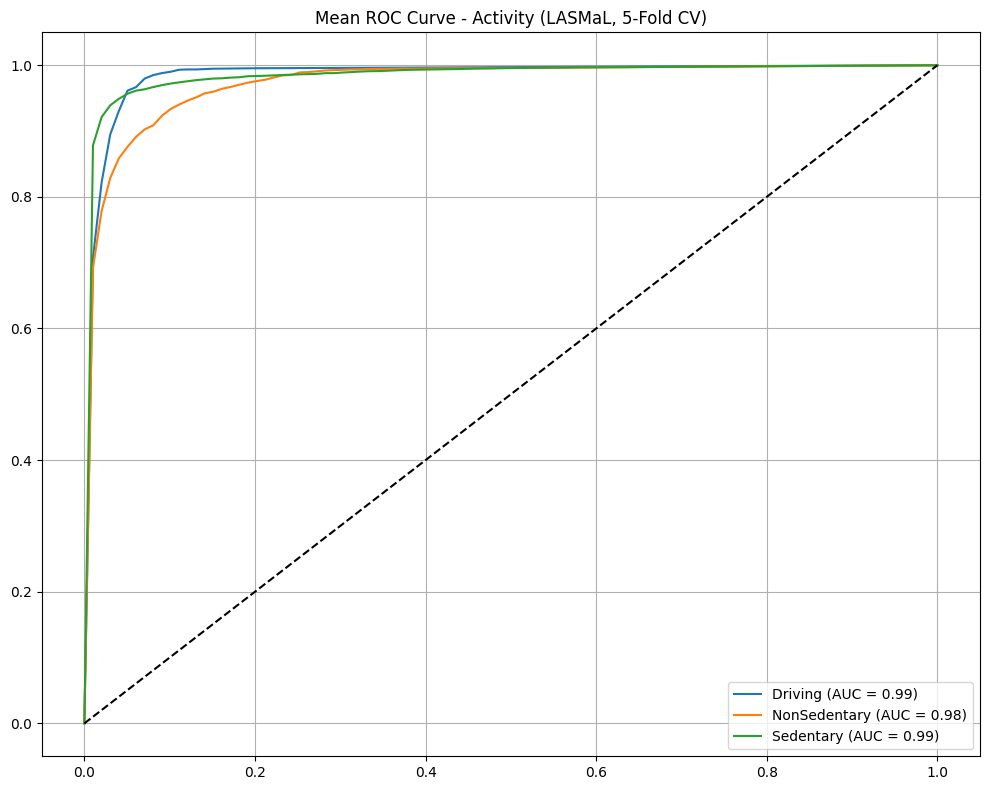

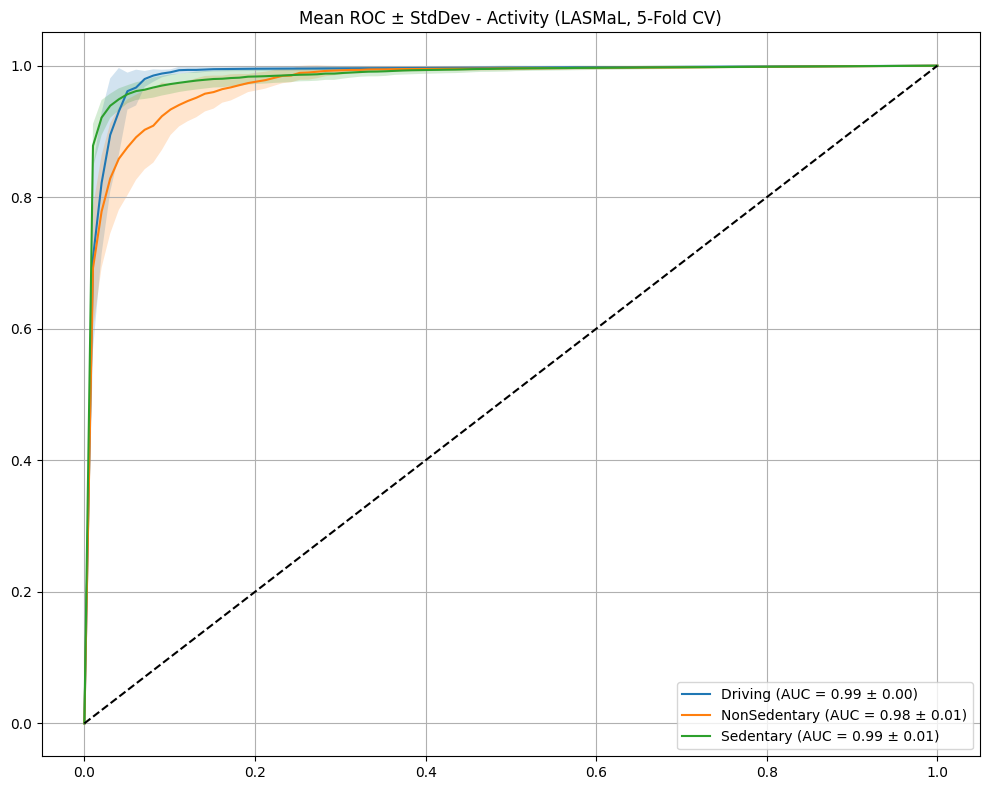


📊 Classification Report (LASMaL):
              precision    recall  f1-score      support
Driving        0.742638  0.871525  0.801936   1331.00000
NonSedentary   0.728351  0.853776  0.786092   1655.00000
Sedentary      0.989965  0.956281  0.972832  15165.00000
accuracy       0.940720  0.940720  0.940720      0.94072
macro avg      0.820318  0.893861  0.853620  18151.00000
weighted avg   0.947975  0.940720  0.943273  18151.00000


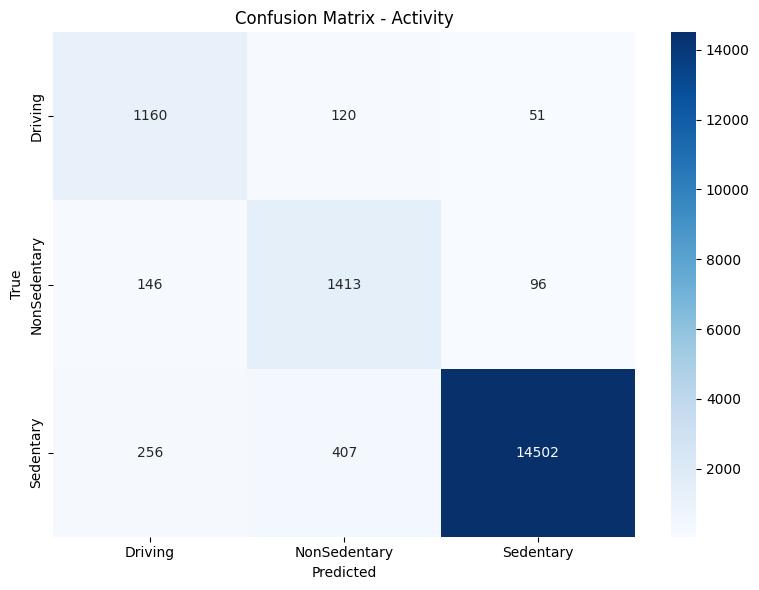

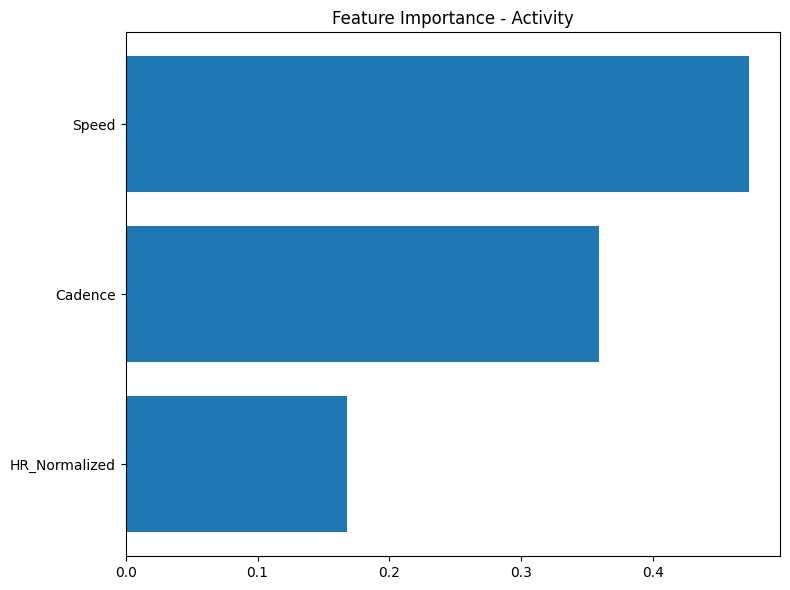


💾 Model saved to: savedmodels/models_k5_lasmal_RandomForest/Activity_best_model_lasmal.pkl
💾 Label encoder saved to: savedmodels/models_k5_lasmal_RandomForest/Activity_label_encoder_lasmal.pkl


In [9]:
# Use 5-fold cross-validation
run_LASMaL_random_forest_training(
    activity_column='Activity',
    csv_path='Activity_Stress_data_N24_with_Activity.csv',
    k=5,
    save=True,
    save_dir='savedmodels/models_k5_lasmal_RandomForest'
)
